### Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

### Introduction
You're already familiar with the use of `keras.Sequential()` to create models. The Functional API is a way to create models that is more flexible than `Sequential`: it can handle models with non-linear topology, models with shared layers, and models with multiple inputs or outputs.

It's based on the idea that a deep learning model is usually a directed acyclic graph (DAG) of layers. The Functional API a set of tools for building graphs of layers.

Consider the following model:

```
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: probability distribution over 10 classes)
```

It's a simple graph of 3 layers.

To build this model with the functional API, you would start by creating an input node:

In [2]:
from tensorflow import keras

inputs = keras.Input(shape=(784,))

Here we just specify the shape of our data: 784-dimentional vectors. Note that the batch size is always omitted, we only specify the shape of each sample. For an input meant for images of shape `(32, 32, 3)`, we would have used:

In [3]:
img_inputs = keras.Input(shape=(32, 32, 3))

What gets returned, `inputs`, contains information about the shape and dtype of the input data that you expect to feed to your model:

In [4]:
inputs.shape

TensorShape([None, 784])

In [5]:
inputs.dtype

tf.float64

Your create a new node in the graph of lyaers by calling a layer on this `inputs` object:

In [6]:
from tensorflow.keras import layers

dense = layers.Dense(64, activation='relu')
x = dense(inputs)

The "layer call" action is like drawing an arrow from "inputs" to this layer we created. We're "passing" the inputs to the `dense` layer, and out we get `x`.

Let's add a few more layers to our graph of layers:

In [7]:
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

At this point, we can create a `Model` by specifying its inputs and outputs in the graph of layers:

In [8]:
model = keras.Model(inputs=inputs, outputs=outputs)

To recap, here is our full model definition process:

In [9]:
inputs = keras.Input(shape=(784,), name='img')
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')

Let's check out what the model summary looks like:

In [10]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


We can also plot the model as a graph:

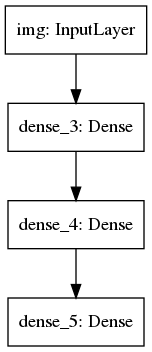

In [11]:
keras.utils.plot_model(model, 'my_first_model.png')

Add optionally display the input and output shapes of each layer in the plotted graph:

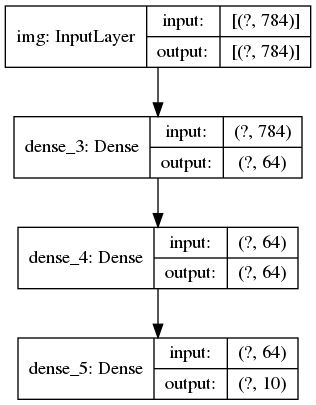

In [17]:
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

This figure and the code we wrote are virtually identical. In the code version, the connection arrows are simply replaced by the call operation.

A "graph of layers" is a very intuitive mental image for a deep learning model, and the functional API is a way to create models that closely mirrors this mental image.

### Training, evaluation, and inference
Training, evaluation, and inference work exactly in the same way for models built using the Functional API as for Sequential models.

Here is a quick demonstratin.

Here we load MNIST image data, reshape it into vectors, fit the model on the data (while monitoring performance on a validation split), and finally we evaluate our model on the test data:

In [38]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255.
x_test = x_test.reshape(10000, 784).astype('float32') / 255.

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 7s 139us/sample - loss: 0.0671 - accuracy: 0.9799 - val_loss: 0.1106 - val_accuracy: 0.9682
Epoch 2/5
48000/48000 [==============================] - 6s 135us/sample - loss: 0.0580 - accuracy: 0.9828 - val_loss: 0.1130 - val_accuracy: 0.9702
Epoch 3/5
48000/48000 [==============================] - 6s 124us/sample - loss: 0.0511 - accuracy: 0.9842 - val_loss: 0.1126 - val_accuracy: 0.9701
Epoch 4/5
48000/48000 [==============================] - 6s 124us/sample - loss: 0.0446 - accuracy: 0.9866 - val_loss: 0.1073 - val_accuracy: 0.9730
Epoch 5/5
48000/48000 [==============================] - 6s 122us/sample - loss: 0.0403 - accuracy: 0.9880 - val_loss: 0.1121 - val_accuracy: 0.9719
10000/10000 - 1s - loss: 0.0937 - accuracy: 0.9750
Test loss: 0.09367153628013258
Test accuracy: 0.975


### Saving and serialization
Saving and serialization work exactly in the same way for models built using the Functional API as for Sequential models.

To standard way to save a Functional model is to call `model.save()` to save the whole model into a single file. You can later recreate the same model from this file, even if you no longer have access to the code that created the model.

This file includes:

- The model's architecture
- The model's weight values (which were learned during training)
- The model's training config (what you passed to `compile`), if any
- The optimizer and its state, if any (this enables you to restart training where you left off)

In [43]:
model.save('path_to_my_model.h5')
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model('path_to_my_model.h5')

### Using the same graph of layers to define multiple models
In the functional API, models are created by specifying their inputs and outputs in a graph of layers. That means that a single graph of layers can be used to generate multiple models.

In the example below, we use the same stack of layers to instantiate two models: an `encoder` model that turns image inputs into 16-dimentional vectors, and an end-to-end `autoencoder` model for training.

In [46]:
# encoder
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

# decoder
x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

# autoencoder
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

Note that we make the decoding architecture strictly symmetrical to the encoding architecture, so that we get an output shape that is the same as the input shape `(28, 28, 1)`. The reverse of a `Conv2D` layer is a `Conv2DTranspose` layer, and the reverse of a `MaxPooling2D` layer is an `UpSampling2D` layer.

### All models are callable, just like layers
You can treat any model as if it were a layer, by calling it on an `Input` or on the output of another layer. Note that by calling a model you aren't just reusing the architecture of the model, you're also reusing its weights.

Let's see this in action. Here's a different take on the autoencoder example that creates an encoder model, a decoder model, and chain them in two calls to obtain the autoencoder model:

In [50]:
# encoder
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPool2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPool2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

# decoder
decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

# autoencoder
autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_5 (Glob (None, 16)                0   

As you can see, model can be nested: a model can contain submodels (since a model is just like a layer).

A common use case for model nesting is ensembling. As an example, here's how to ensemble a set of models into a single model that averages their predictions:

In [51]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1, activation='sigmoid')(inputs)
    return keras.Model(inputs, outputs)

model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
ensemble_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            129         input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            129         input_6[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 1)            129         input_6[0][0]                    
____________________________________________________________________________________________